In [ ]:
%%capture
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install sentencepiece
!pip install scipy
!pip install transformers torch
!pip uninstall tensorflow -y
!pip install tensorflow
!pip install --upgrade tensorflow

In [2]:
%%capture
!pip install --upgrade transformers tensorflow keras

ERROR: Operation cancelled by user


In [ ]:
import spacy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from collections import Counter
import time
import logging
from dateutil.parser import parse
import re
from transformers import CamembertTokenizer, CamembertModel
import torch
from sklearn.metrics.pairwise import manhattan_distances
import math
from tqdm import tqdm
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np
from scipy.signal import savgol_filter

# LEMMATISATION

In [ ]:
df = pd.read_csv('output.csv', sep=';')

In [ ]:
nlp = spacy.load('fr_core_news_sm')

In [ ]:
def clean_and_lemmatize(text):
    if not isinstance(text, str):
        return ""

    doc = nlp(text)

    # Lemmatisation et nettoyage
    tokens = [token.lemma_.lower() for token in doc if token.pos_ not in ['DET', 'ADP', 'ADV'] and not token.is_stop and token.lemma_.isalpha()]

    # Retourner le texte nettoyé et lemmatisé
    return ' '.join(tokens)


In [ ]:
df['text_cleaned'] = df['text'].apply(clean_and_lemmatize)




In [ ]:
df.to_csv('data_cara_lem.csv')


# ANALYSE DE SENTIMENT

In [ ]:
df = pd.read_csv('data_cara_lem.csv')

In [ ]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def analyze_sentiment_batch(texts, batch_size=200):
    model.eval()  # Mettre le modèle en mode évaluation
    weighted_sentiment_scores = []  # Liste pour stocker les scores pondérés

    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Sentiments"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)  # Obtient les probabilités pour chaque classe

            # Calcul des scores pondérés
            # Supposons que les étiquettes sont numérotées de 1 à 5
            stars = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32).to(device)
            weighted_scores = (probs * stars).sum(dim=1)  # Score pondéré pour chaque prédiction
            weighted_sentiment_scores.extend(weighted_scores.cpu().numpy())

    return weighted_sentiment_scores

In [ ]:
df['text'] = df['text'].astype(str)
sentiment_scores = analyze_sentiment_batch(df['text'].tolist())

# Ajouter les scores de sentiment au DataFrame
df['sentiment_score'] = sentiment_scores

df.to_csv('data_cara_wsent.csv', index=False)


Analyzing Sentiments: 100%|██████████| 449/449 [47:59<00:00,  6.41s/it]


In [ ]:
df = pd.read_csv('data_cara_wsent.csv', sep=',')

<ipython-input-5-6ef139233b0e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_period['sentiment_smoothed'] = df_first_period['sentiment_score'].rolling(window=50, center=True).mean()
<ipython-input-5-6ef139233b0e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_period['sentiment_smoothed'] = df_second_period['sentiment_score'].rolling(window=50, center=True).mean()
<ipython-input-5-6ef139233b0e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

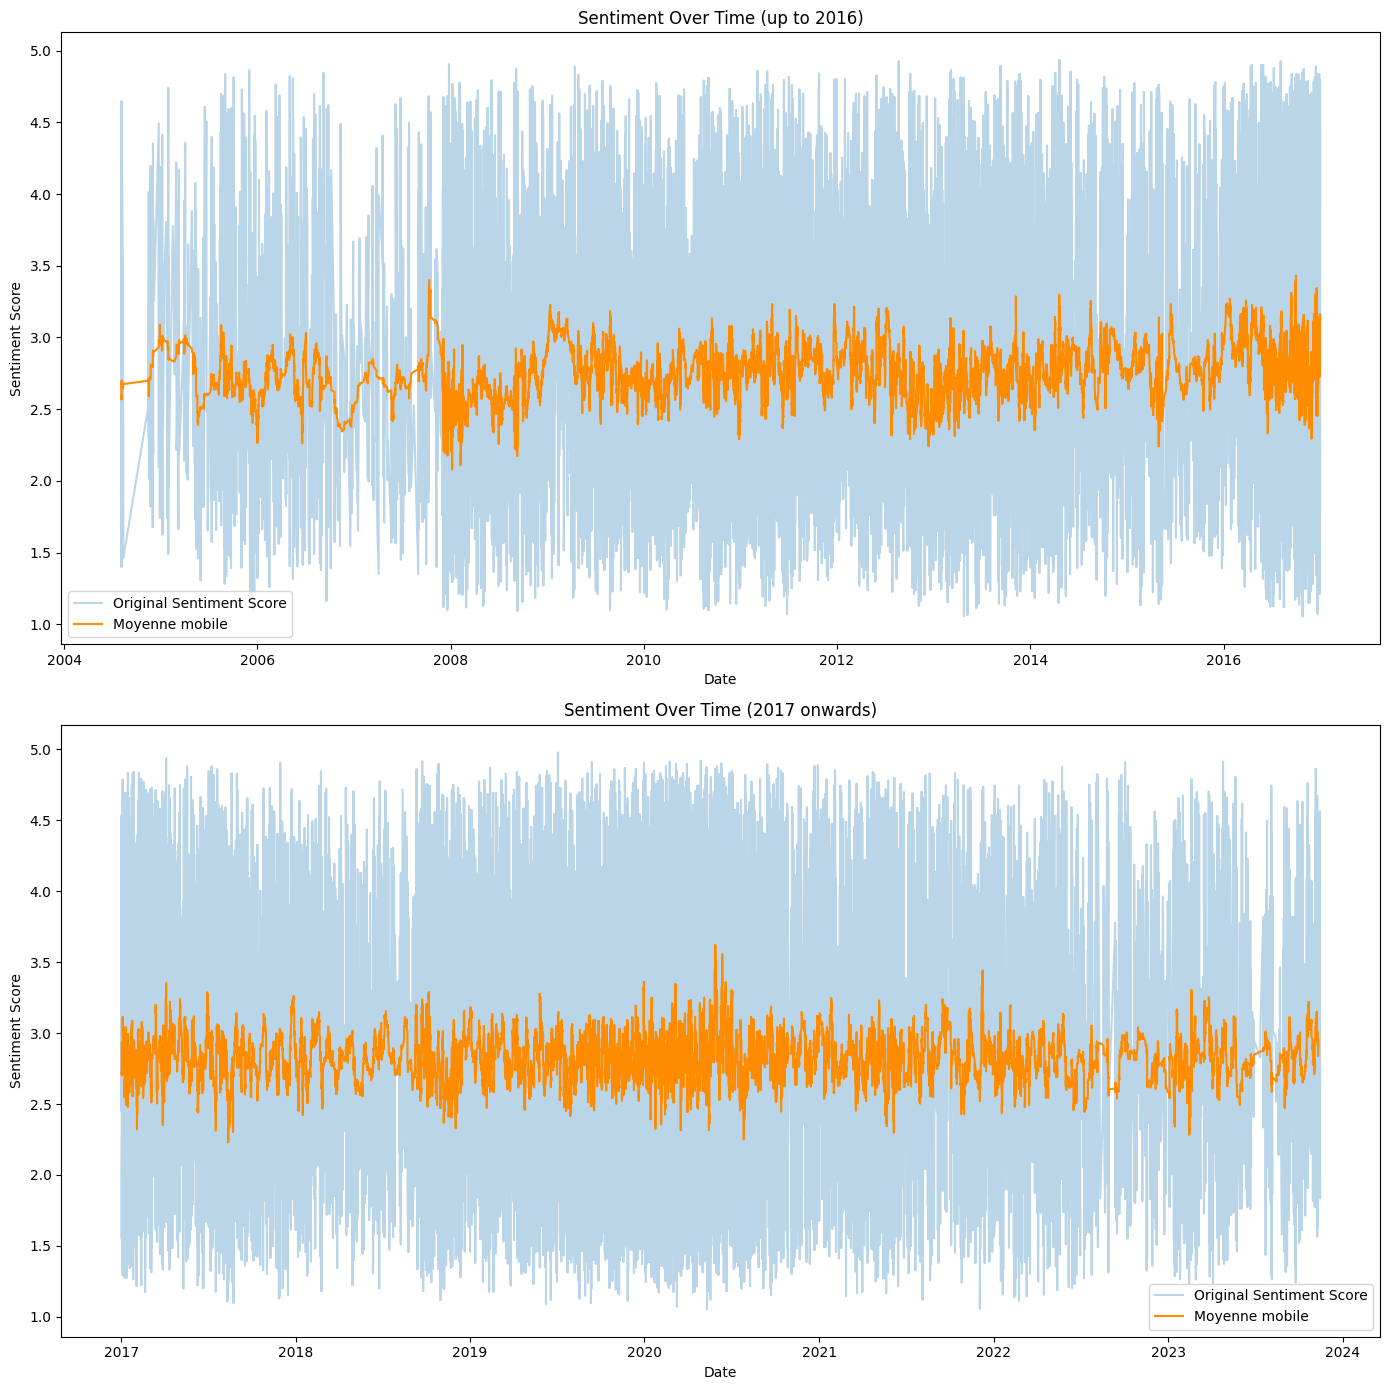

In [ ]:
######## MAIN VISUALISATION


df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

df.sort_values('date', inplace=True)

df_first_period = df[df['date'] <= '2016-12-31']
df_second_period = df[df['date'] > '2016-12-31']

df_first_period['sentiment_smoothed'] = df_first_period['sentiment_score'].rolling(window=50, center=True).mean()
df_second_period['sentiment_smoothed'] = df_second_period['sentiment_score'].rolling(window=50, center=True).mean()

window_size = 51
polynomial_order = 3

df_first_period['sentiment_smoothed_sg'] = savgol_filter(df_first_period['sentiment_smoothed'].fillna(df_first_period['sentiment_score']), window_size, polynomial_order)
df_second_period['sentiment_smoothed_sg'] = savgol_filter(df_second_period['sentiment_smoothed'].fillna(df_second_period['sentiment_score']), window_size, polynomial_order)

plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(df_first_period['date'], df_first_period['sentiment_score'], alpha=0.3, label='Original Sentiment Score')
plt.plot(df_first_period['date'], df_first_period['sentiment_smoothed'], color='darkorange', label='Moyenne mobile')
plt.title('Analyse de sentiment pre 2016')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_second_period['date'], df_second_period['sentiment_score'], alpha=0.3, label='Original Sentiment Score')
plt.plot(df_second_period['date'], df_second_period['sentiment_smoothed'], color='darkorange', label='Moyenne mobile')
plt.title('Analyse de sentiment post 2017')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
#### FONCTION POUR SENTIMENT PAR TOPIC DE FORUM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

df['text_cleaned'] = df['text_cleaned'].dropna().astype(str)
texts = df['text_cleaned'].tolist()
themes = df['theme'].tolist()

def analyze_sentiment_batch_by_theme(texts, themes, batch_size=200):
    model.eval()
    sentiment_scores_by_theme = {}

    for theme in set(themes):
        theme_texts = [text for text, th in zip(texts, themes) if th == theme]

        if not theme_texts:
            print(f"No texts to process for theme: {theme}")
            continue

        weighted_sentiment_scores = []

        for i in tqdm(range(0, len(theme_texts), batch_size), desc=f"Analyzing Sentiments for theme: {theme}"):
            batch_texts = theme_texts[i:i + batch_size]


            if not batch_texts:
                print(f"No more texts to process in batch starting at index {i} for theme: {theme}")
                continue

            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = inputs.to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                stars = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32).to(device)
                weighted_scores = (probs * stars).sum(dim=1)
                weighted_sentiment_scores.extend(weighted_scores.cpu().numpy())

        sentiment_scores_by_theme[theme] = weighted_sentiment_scores

    return sentiment_scores_by_theme



# ENTROPIE

In [ ]:
def calculate_entropy(words):
    word_counts = Counter(words)
    total_words = sum(word_counts.values())
    entropy = -sum((count/total_words) * math.log2(count/total_words) for count in word_counts.values())
    return entropy

# Fonction pour extraire les mots et calculer l'entropie pour chaque groupe
def entropy_by_theme_date(df):
    # Groupe par theme et date
    grouped = df.groupby(['theme', 'date'])

    # Calculer l'entropie pour chaque groupe
    entropy_results = grouped['text_cleaned'].apply(lambda texts: calculate_entropy(' '.join(texts).split()))

    return entropy_results.reset_index(name='entropy')

# Appliquer la fonction à votre DataFrame
entropy_df = entropy_by_theme_date(df)

In [ ]:
# Calculer la moyenne mobile de l'entropie
window_size = 5  # La taille de la fenêtre peut être ajustée selon les besoins
rolling_entropies = entropy_df.set_index('date').groupby('theme')['entropy'].rolling(window=window_size, center=True, min_periods=1).mean().reset_index()

# Visualiser les entropies lissées
plt.figure(figsize=(20, 12))
for theme, group in rolling_entropies.groupby('theme'):
    plt.plot(group['date'], group['entropy'], label=theme)

plt.title(f"Entropie hebdomadaire des mots - lissage avec moyenne mobile sur une fenêtre de {window_size}")
plt.xlabel("Date")
plt.ylabel("Entropie moyenne")
plt.xticks(rotation=90)
plt.legend(title='Theme')
plt.grid(True)

plt.tight_layout()